In [12]:
"""

RBM with a predictor

"""


'\n\nRBM with a predictor\n\n'

In [44]:

"""

ESN Implementation imported from: https://github.com/cknd/pyESN/blob/master/pyESN.py

Initialisation of reservoir weights and input weights done according to Jaeger's paper,
and implementation of augmented training algorithm following the paper:
    https://papers.nips.cc/paper/2318-adaptive-nonlinear-system-identification-with-echo-state-networks.pdf  

Readout training with Moore-Penrose Matrix Inverse or Ridge Regression (added)

Changes for Otsuka's model architecture:
    - sigmoid function for update of memory layer (reservoir units)
    - ???? initialisation of reservoir weights
    - default out activation: tanh
    - get_states method to work with continuation
    - fit and predict methods take reservoir units (output from get_states) directly
Intrinsic Motivation Schmidhuber
    - history object: for each n in N_T (episodes*num_steps): [state, action, state2, reward]
    - evalHistory and calculateReward methods

"""

import numpy as np
from sklearn.linear_model import Ridge
from cannon_rlsfilter import RLSFilterAnalyticIntercept
#import warnings
#warnings.filterwarnings("error")


def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.
    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s
    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


# sigmoid with gain to mimic tanh
def sigmoid(x, gain=4):
    return 1 / (1 + np.exp(-gain*x))

# !!! do I apply the gain to the predictions as well?
def inv_sigmoid(x, gain=1):
    return np.log( (x*gain) / (1 - (x*gain) ) )


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0,
                 noise=0.001,
                 readout='pseudo-inverse',
                 ridge_reg=None,
                 input_weights_scaling = 1,
                 input_scaling=None,input_shift=None,teacher_forcing=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=np.tanh, inverse_out_activation=np.arctanh,
                 silent=True, 
                 augmented=False,
                 transient=200
                 ):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            readout: type of readout 0 can be moonrose pseudo-inverse or ridge regression
            ridge_reg: regularisation value alpha if readout is Ridge
            
            input_weights_scaling: scaling of the input connection weights
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.                       
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
                        
            teacher_shift: additive term applied to the target signal
            teacher_scaling: factor applied to the target signal
            teacher_forcing: if True, feed the target back into output units

            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
    
            silent: supress messages
            augmented: if True, use augmented training algorithm
            transient: how many initial states to discard
            
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs   # part will be obs, part will be reward
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.readout = readout
        self.ridge_reg = ridge_reg
        
        self.input_weights_scaling = input_weights_scaling
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_shift = teacher_shift
        self.teacher_scaling = teacher_scaling
        self.teacher_forcing = teacher_forcing

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation

        self.silent = silent
        self.augmented = augmented
        self.transient = transient
        
        self.laststate = np.zeros(self.n_reservoir)
        self.lastextendedstate = np.zeros(self.n_reservoir+self.n_inputs)
        self.lastinput = np.zeros(self.n_inputs)
        self.lastoutput = np.zeros(self.n_inputs)
        
        self.initweights()
        
    def initweights(self):
        
        # initialize recurrent weights:
        self.W = self.initialise_reservoir()
            
        # [nk] following Jaeger's paper:
        # added scaling
        self.W_in = np.random.uniform(low = -0.1, high = 0.1, size = (self.n_reservoir, self.n_inputs))*self.input_weights_scaling
             
        # random feedback (teacher forcing) weights:
        self.W_feedb = np.random.RandomState().rand(
            self.n_reservoir, self.n_outputs) * 2 - 1
                
        # filter for online learning
        self.RLSfilter = RLSFilterAnalyticIntercept(self.n_reservoir+self.n_inputs, self.n_outputs, forgetting_factor=0.995)
          
        
    def initialise_reservoir(self):
        
        # [nk] following Jaeger's paper:
        W = np.random.uniform(low = -1, high = 1, size = (self.n_reservoir, self.n_reservoir))
        # delete the fraction of connections given by (self.sparsity):
        W[np.random.RandomState().rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        # if radius = 0, reinitialise weights again randomly
        try:
            W = W * (self.spectral_radius / radius)
        except:
            self.initialise_reservoir()
              
        return W
    
    def resetState(self):
        self.laststate = np.zeros(self.n_reservoir)
        self.lastextendedstate = np.zeros(self.n_reservoir+self.n_inputs)
        self.lastinput = np.zeros(self.n_inputs)
        self.lastoutput = np.zeros(self.n_inputs)

    def _update(self, state, input_pattern, output_pattern=None):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern)
                             )
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             )
            
        # [nk] add noise - the original code added noise after applying non-linearity!
        preactivation = preactivation + self.noise * (np.random.uniform(0,1,self.n_reservoir))
        
        activation = sigmoid(preactivation)
        
        return activation

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled
    
    
    def get_states(self, inputs, extended, continuation, outputs=None, inspect=False):
        """
        [nk]
        Collect the network's neuron activations.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's states for every input sample
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        
        if outputs is not None and outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))

        n_samples = inputs.shape[0]
            
        # use last state, input, output
        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)
            
        if not self.silent:
            print("harvesting states...")    

        # create scaled input and output vector
        inputs_scaled = np.vstack([lastinput, self._scale_inputs(inputs)])
        if outputs is not None:
            teachers_scaled = np.vstack([lastoutput, self._scale_teacher(outputs)])
        # create states vector
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        
        
        if self.augmented:
            # create extended states vector
            lastaugmentedstate = np.hstack((np.hstack((lastinput, laststate)),
                                                        np.hstack((np.power(lastinput,2),np.power(laststate,2)))
                                                        ))
            augmented_states = np.vstack(
                    [lastaugmentedstate,np.zeros((n_samples, self.n_reservoir*2+2))])
            
        
        # activate the reservoir with the given input:
        for n in range(1, n_samples+1):
            if outputs is not None:
                states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])
            else:
                states[n, :] = self._update(states[n - 1], inputs_scaled[n, :])
            
            if self.augmented:
                # x_squares(n) =  (u(n), x1(n), ... , xN(n), u^2(n), x1^2(n), ... , xN^2(n))
                # ! teacher forcing version missing
                augmented_states[n,:] = np.hstack((np.hstack((inputs_scaled[n,:],states[n,:])),
                                                        np.hstack((np.power(inputs_scaled[n,:],2),np.power(states[n,:],2)))
                                                        ))
        # include the raw inputs for states
        extended_states = np.hstack((inputs_scaled, states))
        
        # remember the last state, input, output for later:
        self.laststate = states[-1, :]
        self.lastextendedstate = extended_states[-1,:]
        self.lastinput = inputs_scaled[-1, :]
        if outputs is not None:
            self.lastoutput = teachers_scaled[-1, :]
        
        # output states
        if self.augmented:
            out = augmented_states
        elif extended:
            out = extended_states
        else:
            out = states
       
        return out[1:]    #output without last state

    def fit(self, outputs, inputs, continuation, inspect=False):
        """
        [nk]
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform teacher signal:
        teachers_scaled = self._scale_teacher(outputs)
        
        # [nk] collect reservoir states
        states = self.get_states(inputs, extended=True, continuation=continuation)

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        
        # Solve for W_out:
        if self.readout == 'pseudo-inverse':
            self.W_out = np.dot(np.linalg.pinv(states[self.transient:, :]),
                        self.inverse_out_activation(teachers_scaled[self.transient:, :])).T
        elif self.readout == 'ridge':
            self.readout = Ridge(alpha=self.ridge_reg)
            self.readout.fit(states[self.transient:, :], teachers_scaled[self.transient:, :])
        else:
            raise ValueError('Invalid readout parameter: Must be either "ridge" or "pseudo-inverse".')

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        # apply learned weights to the collected states:
        if not self.silent:
            print("training (squared mean squared) error:")
        if self.readout == 'pseudo-inverse': 
            pred_train = self._unscale_teacher(self.out_activation(
                    np.dot(states, self.W_out.T)))
        else:   #ridge
            pred_train = self._unscale_teacher(self.readout.predict(states))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    
    def predict(self, states):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            states: the reservoir of the network which has been activated by the input
        Returns:
            Array of output activations
        """
        n_samples = states.shape[0]
          
        # output predictions for each input
        outputs = np.zeros((n_samples, self.n_outputs))
        for n in range(n_samples):
            if self.readout == 'pseudo-inverse':
                outputs[n, :] = self.out_activation(np.dot(self.W_out,states[n,:]))
            else:   # ridge
                outputs[n, :] = self.readout.predict(states[n,:].reshape(1,-1))
        
        unscaled_outputs = self._unscale_teacher(outputs)
        
        return unscaled_outputs 
    
    # array to store all obs + rewards
    def setHistory(self, episodes, steps):
        num_elem_hist = self.n_inputs + self.n_outputs
        self.history = np.repeat(-1, episodes*steps*num_elem_hist).reshape(episodes, steps, num_elem_hist)
    
    # activate the network for each input of the history and create predictions
    # evaluate the network by calculating the mse on the predictions vs the teacher outputs from the history
    def evalHistory(self, allEpisodes=True):
        if allEpisodes:
            
            num_elem_hist = self.n_inputs + self.n_outputs
            hist = self.history[self.history != -1]  # take all time steps that happened
            hist = hist.reshape(int(len(hist)/num_elem_hist),num_elem_hist) # reshape into (all time steps, hist elements)
            inputs = hist[:,:self.n_inputs]
            teachers = hist[:,self.n_inputs:]    
            
            self.lastoutput = teachers[-1,:]  # save last output for the update of the weights
            
            res_states = self.get_states(inputs, extended=True, continuation=True)
            # get predictions by applying the rls filter and then applying the activation function
            preds = np.zeros((inputs.shape[0], self.n_outputs))
            for i in range(inputs.shape[0]):
                preds[i,:] = self.out_activation(self.RLSfilter.predict(res_states[i,:].reshape(-1,1)).T)       
           
            # calculate predictor quality
            quality = np.mean((preds - teachers)**2)
            
        return quality
    
    # internal reward: evaluate the current network on the history, fit it to the last teacher output from the history,
    # evaluate the new network, return difference between the two
    # Schmidhuber --> int_reward = C(p_old, hist) - C(p_new, hist)
    def calculateInternalReward(self):
        
        # calc C(p_old, hist)
        quality1 = self.evalHistory()
        
        # update filter with last input-output
        self.RLSfilter.process_datum(self.lastextendedstate.reshape(-1,1), self.lastoutput.reshape(-1,1))
        
        # calc C(p_new, hist)
        self.quality = self.evalHistory()
        
        return (quality1 - self.quality)
    


In [45]:
"""
Code for ising taken from Aguilera's code for "Adaptation to Criticality":
Changes:
- Restricted - connections within hidden layer not being updated
- Embodiment for environment Frozen Lake
- RL Learning by a variant of SARSA - to Hinton's paper "Using Q-energies"
     *using sensors and motors variables (not the state variable)
     
For Otsuka's model architecture:
- Memory layer
- Predictor ESN as parameter so it can have access to its reservoir and history
- Sensors are 0/1 for SARSA learning and -1/1 for critical learning
- SARSA learning includes updating the predictor's history and getting its internal reward

""" 


import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import gym

import pdb


class ising:
    # Initialize the network
    def __init__(self, netsize, Nmemory, Nsensors=1, Nmotors=1, predictor=None):  # Create ising model

#         pdb.set_trace()
        
        self.size = netsize		#Network size
        self.Ssize = Nsensors  # Number of sensors
        self.Msize = Nmotors  # Number of motors
        self.Memsize = Nmemory # Number of memory units
        self.Inpsize = Nsensors + Nmemory  # Number of sensors+memory

        self.h = np.zeros(netsize) # local biases
        self.J = np.zeros((netsize, netsize)) # symmetic weights between hidden variables
        self.max_weights = 2          # why do we need to restrict the weights to a maximum value?

        self.randomize_state() # initialisation of states s and sensors s
        
        if predictor is not None:
            self.predictor = predictor

        self.env = gym.make('FrozenLake8x8-v0')
        self.observation = self.env.reset()
        self.maxobs = 64   # !!!!!! For frozen Lake
        self.maxact = 4

        self.BetaCrit = 1.0  
        self.defaultT = max(100, netsize * 20)
        
        self.defaultGamma = 0.999  # as in Otsuka - Solving POMPDs
        self.defaultLr = 0.01  # as in Otsuka - Solving POMPDs

        self.Ssize1 = 0
        
        self.rewardsPerEpisode = 0     #keep track of rewards (for crit)
        self.successfulEpisodes = 0
        
    # method when using SARSA learning. Initialisation acc to Otsuka's thesis
    def initialise_wiring(self):
        self.J = np.random.normal(0, 0.1, (self.size, self.size))

    def get_state(self, mode='all'):
        if mode == 'all':
            return self.s
        elif mode == 'motors':
            return self.motors
        elif mode == 'sensors': 
            return self.s[0:self.Inpsize]
        elif mode == 'input':
            return self.sensors
        elif mode == 'non-sensors':
            return self.s[self.Inpsize:]
        elif mode == 'hidden':
            return self.s[self.Inpsize:-self.Msize]

    # gets the index of the configuration of the neurons - state as one number
    def get_state_index(self, mode='all'):
        return bool2int(0.5 * (self.get_state(mode) + 1))

    # Randomize the state of the network
    def randomize_state(self):
        
        self.s = np.random.randint(0, 2, self.size) * 2 - 1           # make units -1 or 1 
        # the sensors act as biases to the sensor states
        # !! does it make sense to randomise the memory as well?
        self.sensors = np.random.randint(0, 2, self.Inpsize) * 2 - 1    # make sensor inputs -1 or 1

    # Randomize the position of the agent
    def randomize_position(self):
        self.observation = self.env.reset()

    # Set random bias to sets of units of the system
    # bias to hidden and action
    def random_fields(self, max_weights=None):
        if max_weights is None:
            max_weights = self.max_weights
        self.h[self.Inpsize:] = max_weights * \
            (np.random.rand(self.size - self.Inpsize) * 2 - 1)

    # Set random connections to sets of units of the system
    def random_wiring(self, max_weights=None):  # Set random values for J
        if max_weights is None:
            max_weights = self.max_weights
        for i in range(self.size):
            for j in np.arange(i + 1, self.size):
                if i < j and (i >= self.Inpsize or j >= self.Inpsize):  # don't add connections between the sensors
                    # what about the motors? connection between the two will be added: doesn't matter because the correlations are not considered?
                    self.J[i, j] = (np.random.rand(1) * 2 - 1) * self.max_weights
        # get rid of connections between hidden units, and also motor (still dont know why this hasnt been done)
        self.J[self.Inpsize:-self.Msize,self.Inpsize:-self.Msize] = 0  # between hidden
        self.J[:self.Inpsize,-self.Msize:] = 0             # between sensor and motor
        self.J[-self.Msize:,-self.Msize:] = 0            # between motor

    # Update the position of the agent
    def Move(self):
        action = int(np.digitize(
            np.sum(self.s[-self.Msize:]) / self.Msize, [-2, -1/2, 0, 1/2, 2])) - 1
        observation, reward, done, info = self.env.step(action)
        
        self.observation = observation  # update latest observation
        self.action = action
        
        self.rewardsPerEpisode += reward    #update rewards per episode
        self.observations[(self.observations == -1).argmax()] = observation      #add to list woth visited states

    # Transorm the sensor/motor input into integer index
    def InputToIndex(self, x, xmax, bitsize):
        return int(np.floor((x + xmax) / (2 * xmax + 10 * np.finfo(float).eps) * 2**bitsize))
    
    # Update the state of the sensor
    def UpdateSensors(self, state=None, memory=None):
        if state is None:  # it is for critical learning: {-1; 1}
            self.sensors[:self.Ssize] = 2 * bitfield(self.observation, self.Ssize) - 1
            self.sensors[self.Ssize:self.Inpsize] = 2 * memory - 1
        else:              # it is for noncritical, sarsa learning: {0; 1}
            self.sensors = self.createJointInput(state, memory)
       
    # Create state nodes for ESN to be observation from env + predictor's memory
    # observation is binarised {0; 1}, linear memory nodes are used directly
    def createJointInput(self, state, memory):
        inp = np.zeros(self.Inpsize)
        inp[:self.Ssize] = bitfield(self.InputToIndex(state, self.maxobs, self.Ssize), self.Ssize) # binarise observation
        inp[self.Ssize:self.Inpsize] = memory  # use memory directly - better performance
        return inp
        
    # Update the state of the motor?
    def UpdateMotors(self, action):
        self.motors = bitfield(action, self.Msize)
#        self.motors = bitfield(self.InputToIndex(action, self.maxact, self.Msize), self.Msize)

    # Execute step of the Glauber algorithm to update the state of one unit
    def GlauberStep(self, i=None): 
        if i is None:
            i = np.random.randint(self.size)

        I = 0
        if i < self.Inpsize:
            I = self.sensors[i]
        eDiff = 2 * self.s[i] * (self.h[i] + I +
                                 np.dot(self.J[i, :] + self.J[:, i], self.s))
        if eDiff * self.BetaCrit < np.log(1 / np.random.rand() - 1):    # Glauber
            self.s[i] = -self.s[i]

    # Update random unit of the agent
    def Update(self, i=None):
        if i is None:
            i = np.random.randint(-1, self.size)
        if i == -1:
            self.Move()
            
            # m' = f(s, a)  
            state_bit = bitfield(self.sensors, self.Ssize)     # (self.sensors = s, self.observation = s')
            action_bit = bitfield(self.action, self.Msize)     # (self.action = a)
            esn_input = np.hstack([state_bit, action_bit]).reshape(1,-1)
            memory = self.predictor.get_states(esn_input, continuation=True)
            
            self.UpdateSensors(memory=memory)
        else:
            self.GlauberStep(i)

    # Sequentially update state of all units of the agent in random order
    def SequentialUpdate(self):
        for i in np.random.permutation(range(-1, self.size)):
            self.Update(i)

    # Step of the learning algorith to ajust correlations to the critical regime
    def AdjustCorrelations(self, T=None):
          
        if T is None:
            T = self.defaultT

        self.m = np.zeros(self.size)
        self.c = np.zeros((self.size, self.size))
        self.C = np.zeros((self.size, self.size))

        # Main simulation loop:
        self.x = np.zeros(T)      # to store the positions of the car during all T
        samples = []
        for t in range(T):

            self.SequentialUpdate()
            self.x[t] = self.observation
            self.m += self.s
            for i in range(self.size):
                self.c[i, i + 1:] += self.s[i] * self.s[i + 1:]
        self.m /= T
        self.c /= T
        for i in range(self.size):
            self.C[i, i + 1:] = self.c[i, i + 1:] - self.m[i] * self.m[i + 1:]

        c1 = np.zeros((self.size, self.size))
        for i in range(self.size):
            inds = np.array([], int)
            c = np.array([])
            for j in range(self.size):
                if not i == j:
                    inds = np.append(inds, [j])
                if i < j:
                    c = np.append(c, [self.c[i, j]])
                elif i > j:
                    c = np.append(c, [self.c[j, i]])
            order = np.argsort(c)[::-1]
            c1[i, inds[order]] = self.Cint[i, :]
        self.c1 = np.triu(c1 + c1.T, 1)
        self.c1 *= 0.5

        self.m[0:self.Inpsize] = 0          
        self.m1[0:self.Inpsize] = 0     #sensors have objective mean 0 but in the paper they say it's all of the units but the sensors that have mean 0??
        self.c[0:self.Inpsize, 0:self.Inpsize] = 0    #set corr in between sensors to 0
        self.c[-self.Msize:, -self.Msize:] = 0    #set corr in between motors to 0
        self.c[0:self.Inpsize, -self.Msize:] = 0    #set corr between sensors and motors to 0
        self.c1[0:self.Inpsize, 0:self.Inpsize] = 0
        self.c1[-self.Msize:, -self.Msize:] = 0
        self.c1[0:self.Inpsize, -self.Msize:] = 0
        
        # make it restricted BM
        self.c[self.Inpsize:-self.Msize,self.Inpsize:-self.Msize] = 0   #set corr in between hidden units to 0
        self.c1[self.Inpsize:-self.Msize,self.Inpsize:-self.Msize] = 0   #for reference as well
        
        dh = self.m1 - self.m
        dJ = self.c1 - self.c

        return dh, dJ

    # Algorithm for poising an agent in a critical regime
    def CriticalLearning(self, Iterations, T=None):
        
        self.observations = np.repeat(-1,Iterations*T)    #keep track of reached states
        
        u = 0.01
        count = 0
        dh, dJ = self.AdjustCorrelations(T)
        for it in range(Iterations):
            count += 1
            self.h += u * dh
            self.J += u * dJ

            if it % 10 == 0:
                self.randomize_state()
                self.randomize_position()
                
                if self.rewardsPerEpisode >= 1:     # keep track of the times the agent reached the goal
                    self.successfulEpisodes += 1
                self.rewardsPerEpisode = 0
                
            Vmax = self.max_weights
            for i in range(self.size):
                if np.abs(self.h[i]) > Vmax:        # why do we need to restrict the weights and biases to a maximum value?
                    self.h[i] = Vmax * np.sign(self.h[i])
                for j in np.arange(i + 1, self.size):
                    if np.abs(self.J[i, j]) > Vmax:
                        self.J[i, j] = Vmax * np.sign(self.J[i, j])

            dh, dJ = self.AdjustCorrelations(T)
           
    # Calculate hat_h_k for each k (expert)    
    def ExpectedValueExperts(self, sensors, motors):
        # self.s[Ssize:-Msize] - all hidden
        # self.h[Ssize:-Msize] - biases of hidden
        # self.J[:Ssize,Ssize:-Msize] - sensor-hidden connections
        # self.J[Ssize:-Msize, -Msize:] - hidden-motor conn.
        
        num_e = self.size - (self.Inpsize+self.Msize)  # number of hidden units (experts)
        ve = np.zeros(num_e)             # array of expected values for experts
        for k in range(num_e):
            ve[k] = sigmoid(np.dot(self.J[0:self.Inpsize,self.Inpsize:-self.Msize][:,k], sensors) + 
                            np.dot(self.J[self.Inpsize:-self.Msize, -self.Msize:][k,:], motors) +
                            self.h[self.Inpsize:-self.Msize][k])
        
        return ve
    
    # takes in state and action and uses their binary equivalents to calculate the energy (not the actual network's)
    # state_bit = binarised observation + memory
    # action = the int action
    def CalcFreeEnergy(self, state_bit, action):
        
#         pdb.set_trace()
          
        #binarise action
        action_bit = bitfield(self.InputToIndex(action, self.maxact, self.Msize), self.Msize)
    
        ve = self.ExpectedValueExperts(state_bit, action_bit).reshape(-1,1)  #calculate expected hidden values
        ss = state_bit.reshape(1,-1)
        sm = action_bit.reshape(1,-1) 
        
        # calculate the negative log-likelihood
        a = -np.dot(np.dot(ss, self.J[:self.Inpsize,self.Inpsize:-self.Msize]), ve)    # 1
        b = -np.dot(ss, self.h[:self.Inpsize].reshape(-1,1))                             # 2
        c = -np.dot(np.dot(sm, np.transpose(self.J[self.Inpsize:-self.Msize, -self.Msize:])), ve)  # 3
        d = -np.dot(sm, self.h[-self.Msize:].reshape(-1,1))                            # 4
        e = -np.dot(self.h[self.Inpsize:-self.Msize], ve)                       # 5
        
        # calculate the negative entropy
        f = 0                                                           # 6 + 7
        for k in range(len(ve)):
            f += ve[k]*np.log(ve[k]) + (1 - ve[k])*np.log(1 - ve[k])
        
        return float(a+b+c+d+e+f)
    
    def SarsaLearning(self, total_episodes, max_steps, Beta, gamma=None, lr=None):
        
#         pdb.set_trace()

        self.predictor.setHistory(total_episodes, max_steps)  # create history array 
        self.log = np.tile(np.repeat(-1.0,6),(total_episodes, max_steps,1))  # track learning
        
        for episode in range(total_episodes):
            
            beta = Beta[episode]
            
            #update memory - keeps updating throughout the episodes
            if episode == 0:
                memory = self.predictor.laststate
            else:
                memory = self.predictor.get_states(np.array([state, action]).reshape(1,-1), extended=False, continuation=True)
            
            # reset the environment
            state = self.env.reset()
            # update the sensors
            self.UpdateSensors(state, memory)

            # choose a (action) based on s = obs+m (obs+memory)
            state_memory = self.createJointInput(state, memory)
            action = self.ChooseAction(state_memory, beta)
            self.UpdateMotors(action)
           
            # calculate Q(s,a)
            Q1 = -1*self.CalcFreeEnergy(state_memory, action)

            t = 0
            while t < max_steps:             
                
                # calculate m'
#                esn_input = np.hstack([state_bit, action_bit]).reshape(1,-1)
                esn_input = np.array([state, action]).reshape(1,-1)
                memory2 = self.predictor.get_states(esn_input, extended=False, continuation=True) # we only take state activations, not concatenate states with input which is done to train the weights and to also predict                                                                           
                
                # step with a and receive obs'
                state2, ext_reward, done, info = self.env.step(action)
                
                #--
                
                # Predictor improvement and calculation of internal reward
                self.predictor.history[episode,t,:] = np.array([state, action, state2, ext_reward])  # update predictor history
                int_reward = self.predictor.calculateInternalReward() # calculate internal reward
            
                # Calculation of reward for SARSA update
                reward = int_reward+ext_reward  # reward used for SARSA update
#                reward = int_reward
                
                #--
                
                # choose a' based on s' = obs'+m'
                state_memory2 = self.createJointInput(state2, memory2) # add the predictor's state to the obsrvations
                action2 = self.ChooseAction(state_memory2, beta)
                
                # calculate Q(s',a')
                Q2 = -1*self.CalcFreeEnergy(state_memory2, action2) # calculate Q2 = Q(s',a') = -F(s',a')
                
                # make update to the weights of the network currently having s and a
                self.SarsaUpdate(Q1, reward, Q2, gamma, lr)

                dQ = Q2-Q1
                self.log[episode, t, :] = np.array([state, ext_reward, self.predictor.quality, Q1, int_reward, dQ])
#                 print('episode: '+ str(episode),
#                       ' t:' + str(t),
#                       ' int_reward: ' + str(round(int_reward,4)), # improv. predictor
#                       ' ext_reward: ' + str(ext_reward),
#                       ' dQ: ' + str(round(Q2 - Q1,4)),  # change in free-energy
#                 )

                # updates for loop
                self.UpdateSensors(state2, memory2)  # update the network's sensors to be s' 
                self.UpdateMotors(action2)  # update the network's motors to be a'
                state = state2  # update obs = obs'   (needed to calculate m' = obs + a)
                action = action2  # update a = a'  (needed to calculate m' = obs + a and to also get obs')
                Q1 = Q2  # no need to update m (memory), because Q1 is directly updated

                t += 1

                if done:
                    break

    
    # works with the network's actual sensors and motors
    def SarsaUpdate(self, Q1, reward, Q2, gamma, lr):
        
        if gamma is None:
            gamma = self.defaultGamma
        if lr is None:
            lr = self.defaultLr
        
        rDiff = lr*(reward + gamma * Q2 - Q1)
        
        # calculate dQ/Wsensors
        ve = self.ExpectedValueExperts(self.sensors, self.motors).reshape(1,-1)
        ve_new = np.repeat(ve, len(self.sensors)).reshape(-1,1)
        s_ne = np.repeat(self.sensors.reshape(1,-1), ve.shape[1], axis=0)
        s_new = s_ne.reshape(s_ne.shape[0]*s_ne.shape[1],1)
        dQdWs = np.multiply(ve_new,s_new)
        
        # calculate dQ/Wmotors
        ve_new = np.repeat(ve, len(self.motors)).reshape(-1,1)
        m_ne = np.repeat(self.motors.reshape(1,-1), ve.shape[1], axis=0)
        m_new = m_ne.reshape(m_ne.shape[0]*m_ne.shape[1],1)
        dQdWm = np.multiply(ve_new,m_new)
        
        # update weights of sensors and motors
        num_h = self.size - (self.Inpsize+self.Msize)
        
        dWs = (rDiff*dQdWs).reshape(num_h, self.Inpsize)
        dWm = (rDiff*dQdWm).reshape(num_h, self.Msize)
        
        self.J[:self.Inpsize,self.Inpsize:-self.Msize] = np.transpose(np.transpose(self.J[:self.Inpsize,self.Inpsize:-self.Msize]) + dWs)
        self.J[self.Inpsize:-self.Msize, -self.Msize:] = self.J[self.Inpsize:-self.Msize, -self.Msize:] + dWm
        
        # update biases
        self.h[:self.Inpsize] = self.h[:self.Inpsize] + rDiff*self.sensors
        self.h[-self.Msize:] = self.h[-self.Msize:] + rDiff*self.motors
        self.h[self.Inpsize:-self.Msize] =  self.h[self.Inpsize:-self.Msize] + rDiff*ve
        
    
    # state = observation + memory
    def ChooseAction(self, state, beta):
        
#         pdb.set_trace()
        
        try:
            # calculate probabilities of all actions - based on Otsuka's paper
            p_a = np.zeros((self.env.nA,2))
            for a in range(self.env.nA):
                fa = np.exp(-beta*self.CalcFreeEnergy(state, a))
                fa_ = 0
                for a_ in range(self.env.nA):
                    fa_ = fa_ + np.exp(-beta*self.CalcFreeEnergy(state, a_))
                p_a[a,1] = fa/fa_
                p_a[a,0] = a  #add index column

            # sample an action from the distribution
            ord_p_a = p_a[p_a[:,1].argsort()]
            ord_p_a[:,1] = np.cumsum(ord_p_a[:,1])

            b = np.array(ord_p_a[:,1] > np.random.rand())
            act = int(ord_p_a[b.argmax(),0])  # take the index of the chosen action
        
        except RuntimeWarning:
            pdb.set_trace()
 
        return act
        
        
# Transform bool array into positive integer
# [nk] encodes the state of the neurons as one number
def bool2int(x):
    y = 0
    for i, j in enumerate(np.array(x)[::-1]):
        y += j * 2**i
    return int(y)

# Transform positive integer into bit array
def bitfield(n, size):
    x = [int(x) for x in bin(int(n))[2:]]
    x = [0] * (size - len(x)) + x
    return np.array(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))




In [46]:
import numpy as np
import pdb
import warnings
warnings.filterwarnings("error")

# rbm params
Ssize=7
Msize=2
Nhidden = 20
Nmemory = 12
size=Ssize+Nmemory+Nhidden+Msize

# esn params
predictor_inputs = 2 # linear state,action
predictor_outputs = 2 # linear state2, reward
predictor_radius = 0.9
predictor_sparsity = 0.9

#predictor
predictor = ESN(n_inputs = predictor_inputs, n_outputs = predictor_outputs, n_reservoir=Nmemory,
                 spectral_radius=predictor_radius, sparsity=predictor_sparsity,
                 noise=0.001,
                 readout='pseudo-inverse',
                 ridge_reg=None,
                 input_weights_scaling = 1,
                 out_activation=np.tanh, inverse_out_activation=np.arctanh
                 )

In [47]:


#actor
I = ising(size,Nmemory,Ssize,Msize,predictor)
I.initialise_wiring()

# SARSA RL
total_episodes = 1000   #10000
max_steps = 100         # in Otsuka they are 250 but it's a different task
Beta = np.linspace(0,15,total_episodes)

I.SarsaLearning(total_episodes, max_steps, Beta)


# ### Critical learning


# # Import reference correlations

# filecorr = 'correlations-ising2D-size400.npy'
# Cdist = np.load(filecorr)


# # reorder reference correlations to match network's current correlations
# I.m1 = np.zeros(size)
# I.Cint = np.zeros((size, size - 1))
# for i in range(size):
#     c = []
#     for j in range(size - 1):
#         ind = np.random.randint(len(Cdist))
#         c += [Cdist[ind]]
#     I.Cint[i, :] = -np.sort(-np.array(c))
    
# # Make network critical
# Iterations = 1000
# T = 5000

# I.CriticalLearning(Iterations,T)

MemoryError: Unable to allocate array with shape (11565, 14) and data type float64

In [51]:
num_ep=0
for i in range(total_episodes):
    num_ep=num_ep + 1 if I.log[i,:,:][I.log[i] != -1].shape[0] == 0 else num_ep + 0
num_ep

544

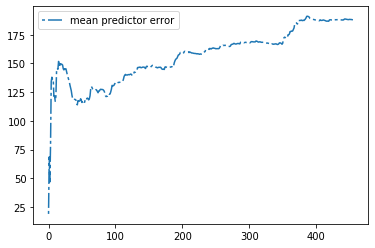

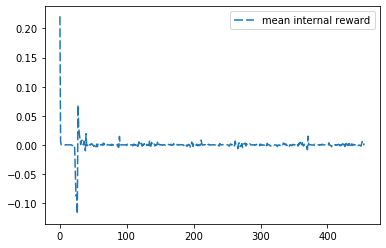

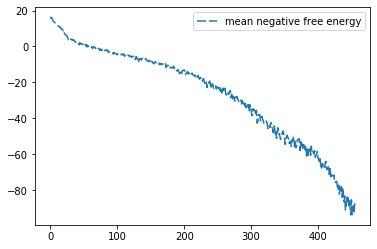

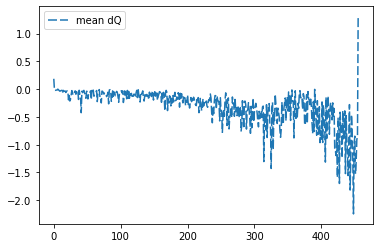

In [76]:
import matplotlib.pyplot as plt
num_el = 6               

episodes_sofar = 456

try:
    res = np.zeros((episodes_sofar, num_el))
    for i in range(episodes_sofar):
        ep = I.log[i,:,:][I.log[i] != -1]
        steps = int(ep.shape[0]/num_el)
        ep = ep.reshape(steps,num_el)
        res[i,0] = np.max(ep[:,0]) # max obs reached
        res[i,1] = np.max(ep[:,1]) # ext reward
        res[i,2] = np.mean(ep[:,2]) # mean pred. quality (mean mse on history so far)
        res[i,3] = np.mean(ep[:,3]) # mean -free energy of the actor
        res[i,4] = np.mean(ep[:,4]) # mean int reward
        res[i,5] = np.mean(ep[:,5]) # mean diff in energies
except:
    pdb.set_trace()
    
# pred errors

x = range(episodes_sofar)
y = res[:,2]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean predictor error')
line1.set_dashes([2, 2, 10, 2])

ax.legend()
plt.show()

# int reward

y = res[:,4]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean internal reward')
line1.set_dashes([6, 2])

ax.legend()
plt.show()

# actor -free energy

y = res[:,3]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean negative free energy')
line1.set_dashes([6, 2])

ax.legend()
plt.show()

# dQ

y = res[:,5]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean dQ')
line1.set_dashes([6, 2])

ax.legend()
plt.show()

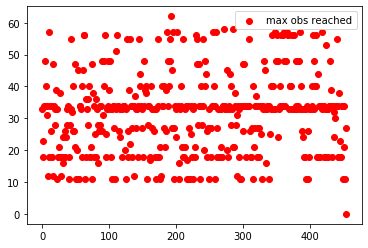

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


{0: [(0.3333333333333333, 54, 0.0, True),
  (0.3333333333333333, 61, 0.0, False),
  (0.3333333333333333, 62, 0.0, False)],
 1: [(0.3333333333333333, 61, 0.0, False),
  (0.3333333333333333, 62, 0.0, False),
  (0.3333333333333333, 63, 1.0, True)],
 2: [(0.3333333333333333, 62, 0.0, False),
  (0.3333333333333333, 63, 1.0, True),
  (0.3333333333333333, 54, 0.0, True)],
 3: [(0.3333333333333333, 63, 1.0, True),
  (0.3333333333333333, 54, 0.0, True),
  (0.3333333333333333, 61, 0.0, False)]}

In [68]:
# max obs reached

y = res[:,0]

fig, ax = plt.subplots()
ax.scatter(x, y, color='r', label='max obs reached')
line1.set_dashes([2, 2, 10, 2])

ax.legend()
plt.show()

np.max(y)
I.env.render()
I.env.P[62]

In [78]:
# I.J[:I.Inpsize,I.Inpsize:-I.Msize]
I.J[I.Inpsize:-I.Msize, -I.Msize:]

array([[-0.48755286, -0.40932715],
       [-0.49688016, -0.53048138],
       [-0.44737829, -0.53050749],
       [-0.73919954, -0.68320807],
       [-0.42736092, -0.49206539],
       [-0.50772862, -0.51034254],
       [-0.53011995, -0.67783393],
       [-0.50959796, -0.41692773],
       [-0.33883035, -0.42465608],
       [-0.52725054, -0.56869498],
       [-0.30736767, -0.35216308],
       [-0.41545944, -0.38714262],
       [-0.42880323, -0.35559161],
       [-0.3724377 , -0.4980805 ],
       [-0.53316377, -0.51395185],
       [-0.49978804, -0.39510699],
       [-0.49316266, -0.50266985],
       [-0.38353771, -0.48639231],
       [-0.44996849, -0.49969315],
       [-0.28747105, -0.45797467]])

In [75]:
np.argwhere(I.predictor.history == 62)
I.predictor.history[193,17:20,:]
I.predictor.history[194,:3,:]

# I.log[i,:,:][I.log[i] != -1]

array([[ 0,  2,  1,  0],
       [ 1,  1,  2,  0],
       [ 2,  1, 10,  0]])

In [ ]:
f = 0                                                           # 6 + 7
        for k in range(len(self.ExpectedValueExperts(state, bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize)).reshape(-1,1))): f += self.ExpectedValueExperts(state, bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize)).reshape(-1,1)[k]*np.log(self.ExpectedValueExperts(state, bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize)).reshape(-1,1)[k]) + (1 - self.ExpectedValueExperts(state, bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize)).reshape(-1,1)[k])*np.log(1 - self.ExpectedValueExperts(state, bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize)).reshape(-1,1)[k])

a=-np.dot(np.dot(state.reshape(1,-1), self.J[:self.Inpsize,self.Inpsize:-self.Msize]), self.ExpectedValueExperts(state, bitfield(self.InputToIndex(action, self.maxact, self.Msize), self.Msize)).reshape(-1,1))
a=-31
-np.dot(state.reshape(1,-1), self.h[:self.Inpsize].reshape(-1,1)) 
b=-14
-np.dot(np.dot(bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize).reshape(1,-1), np.transpose(self.J[self.Inpsize:-self.Msize, -self.Msize:])), self.ExpectedValueExperts(state, bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize)).reshape(-1,1))
c=-19
-np.dot(bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize).reshape(1,-1), self.h[-self.Msize:].reshape(-1,1))
d=-5
-np.dot(self.h[self.Inpsize:-self.Msize], self.ExpectedValueExperts(state, bitfield(self.InputToIndex(a_, self.maxact, self.Msize), self.Msize)).reshape(-1,1))  
e=-9
f=-4

self.ExpectedValueExperts(state, bitfield(self.InputToIndex(action, self.maxact, self.Msize), self.Msize))

num_ep = 0
for i in range(total_episodes):
    add = 1 if I.log[i,:,:][I.log[i] != -1].shape[0] == 0 else 0
    num_ep+=add

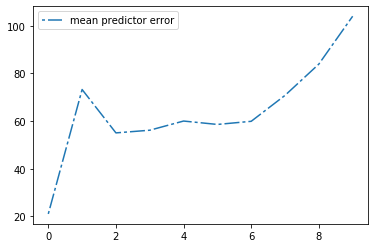

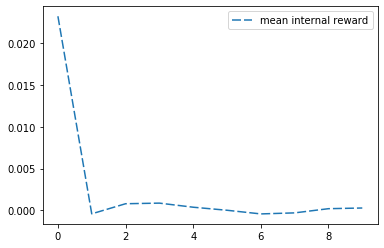

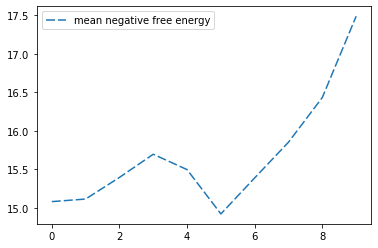

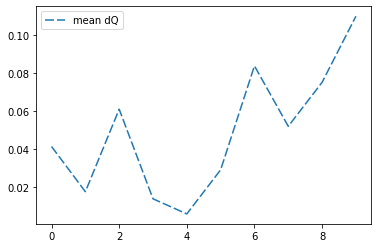

In [81]:
num_ep
for i in range(total_episodes):
    num_ep=num_ep + 1 if I.log[i,:,:][I.log[i] != -1].shape[0] == 0 else num_ep + 0

I.log[-1,:,:][I.log[i] != -1]
.shape[0] == 0
# Plot stats from run

import matplotlib.pyplot as plt
num_el = 6               

res = np.zeros((total_episodes, num_el))
for i in range(total_episodes):
    ep = I.log[i,:,:][I.log[i] != -1]
    steps = int(ep.shape[0]/num_el)
    ep = ep.reshape(steps,num_el)
    res[i,0] = np.max(ep[:,0]) # max obs reached
    res[i,1] = np.max(ep[:,1]) # ext reward
    res[i,2] = np.mean(ep[:,2]) # mean pred. quality (mean mse on history so far)
    res[i,3] = np.mean(ep[:,3]) # mean -free energy of the actor
    res[i,4] = np.mean(ep[:,4]) # mean int reward
    res[i,5] = np.mean(ep[:,5]) # mean diff in energies

# pred errors

x = range(total_episodes)
y = res[:,2]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean predictor error')
line1.set_dashes([2, 2, 10, 2])

ax.legend()
plt.show()

# int reward

y = res[:,4]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean internal reward')
line1.set_dashes([6, 2])

ax.legend()
plt.show()

# actor -free energy

y = res[:,3]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean negative free energy')
line1.set_dashes([6, 2])

ax.legend()
plt.show()

# dQ

y = res[:,5]

fig, ax = plt.subplots()
line1, = ax.plot(x, y, label='mean dQ')
line1.set_dashes([6, 2])

ax.legend()
plt.show()


